#Unzipping the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Dataset/cataract_2.zip

##Importing the Necessary Libraries

In [14]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Input
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import os
import shutil
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

#Spliting the Data Folder to Train, Test, Validation Folders

In [4]:
def split_data(data_dir, save_dir, train_ratio, test_ratio, valid_ratio):
    train_dir = os.path.join(save_dir, 'train')
    valid_dir = os.path.join(save_dir, 'valid')
    test_dir = os.path.join(save_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        train_class_dir = os.path.join(train_dir, class_name)
        valid_class_dir = os.path.join(valid_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(valid_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        files = os.listdir(class_dir)
        random.shuffle(files)

        total_files = len(files)
        train_split = int(train_ratio * total_files)
        test_split = int(test_ratio * total_files)

        train_files = files[:train_split]
        test_files = files[train_split:train_split+test_split]
        valid_files = files[train_split+test_split:]

        for file in train_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(train_class_dir, file)
            shutil.copyfile(src, dst)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(test_class_dir, file)
            shutil.copyfile(src, dst)

        for file in valid_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(valid_class_dir, file)
            shutil.copyfile(src, dst)

    print("Data split into train, valid, and test directories.")
data_dir = "/content/cataract"
save_dir = "/content/split_data"

train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15
split_data(data_dir, save_dir, train_ratio, test_ratio, valid_ratio)

Data split into train, valid, and test directories.


#Visualization of Class Distribution

In [6]:
class_labels = os.listdir(data_dir)

image_counts = []
for label in class_labels:
    class_path = os.path.join(data_dir, label)
    image_count = len(os.listdir(class_path))
    image_counts.append(image_count)

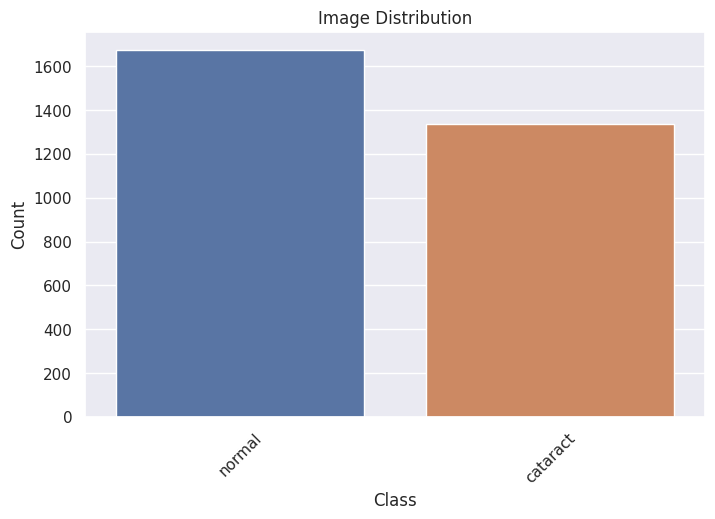

In [7]:
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=image_counts)
plt.title('Image Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

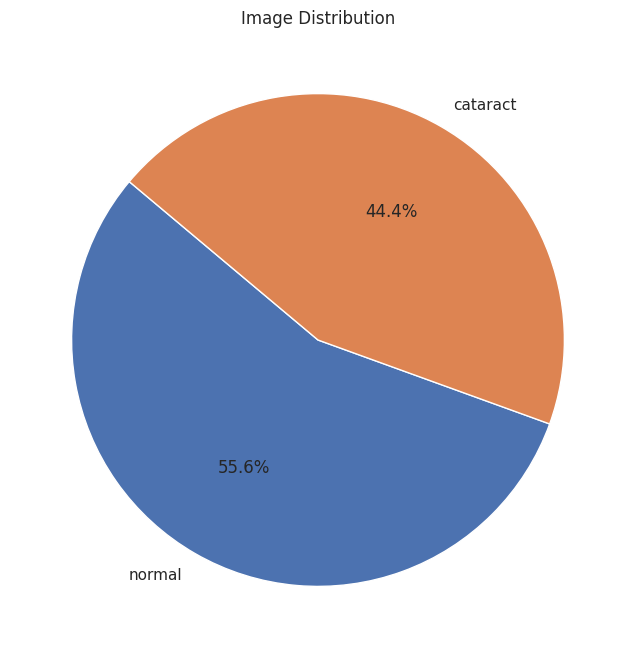

In [8]:
plt.figure(figsize=(8, 8))
plt.pie(image_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Image Distribution')
plt.show()

#Creating Train Set

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   shear_range = 0.1
                                 )
training_set = train_datagen.flow_from_directory('/content/split_data/train',
                                                 target_size = (512,512),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode= 'rgb',
                                                 shuffle=True
                                                 )
training_set.class_indices

Found 2107 images belonging to 2 classes.


{'cataract': 0, 'normal': 1}

#Creating Test Set

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255,)
testing_set = test_datagen.flow_from_directory('/content/split_data/test',
                                                 target_size = (512,512),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode= 'rgb',
                                                 shuffle=True
                                                 )
testing_set.class_indices

Found 451 images belonging to 2 classes.


{'cataract': 0, 'normal': 1}

#Creating Validation Set

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255,)
validation_set = validation_datagen.flow_from_directory('/content/split_data/valid',
                                                 target_size = (512,512),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode= 'rgb',
                                                 shuffle=True
                                                 )
validation_set.class_indices

Found 454 images belonging to 2 classes.


{'cataract': 0, 'normal': 1}

#Show Images From Train Set

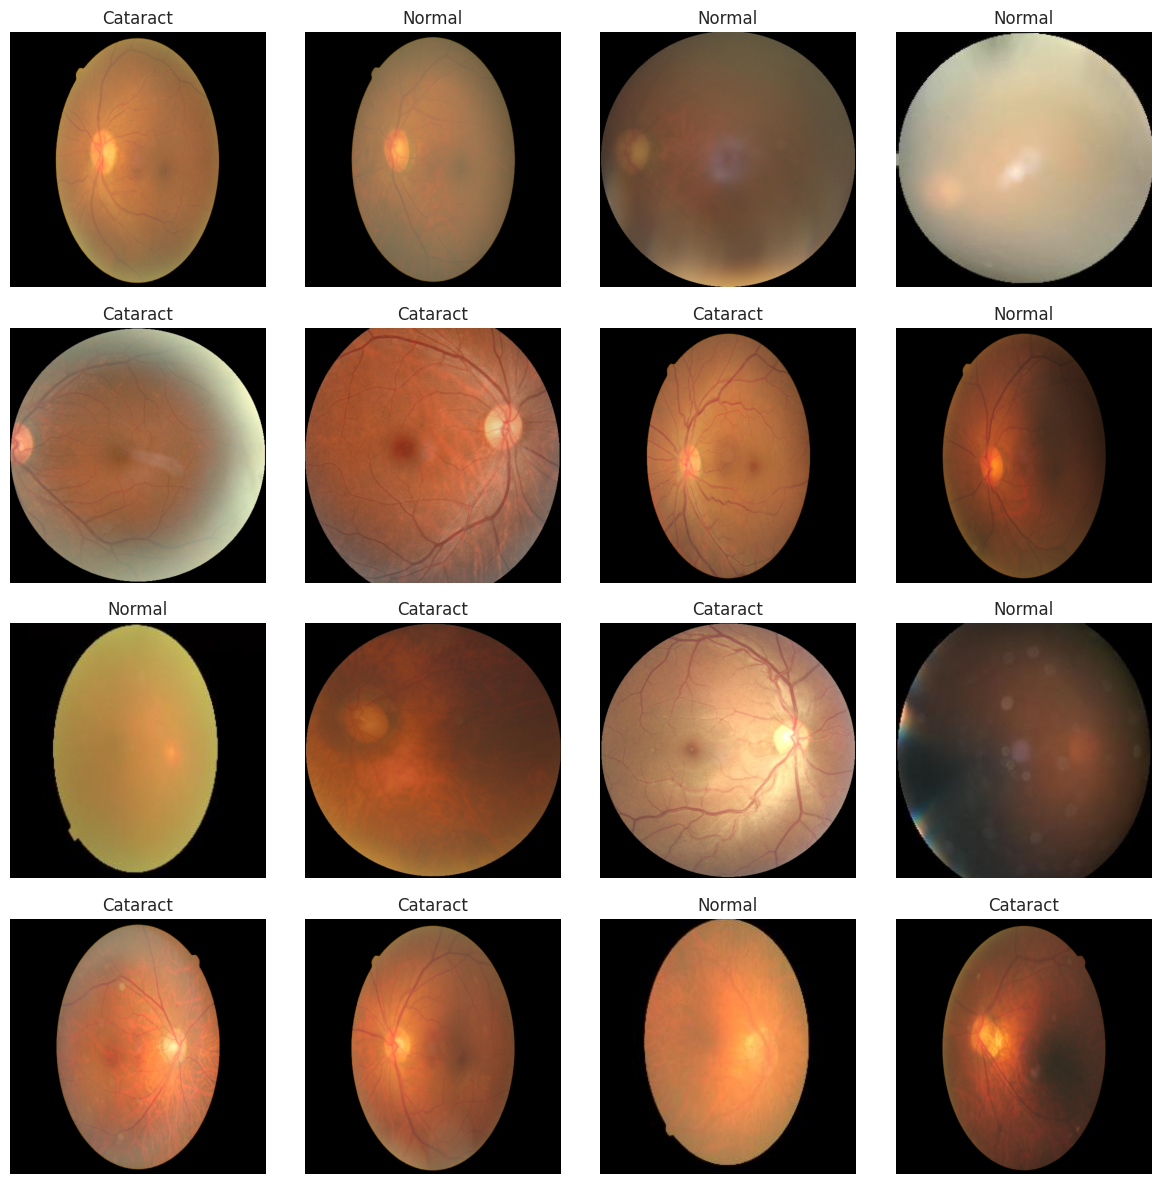

In [19]:
t_img, label = training_set.next()

def plotImages(img_arr, label):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(16):
        img = img_arr[i]
        axes[i].imshow(img)
        axes[i].set_title("Cataract" if label[i][0] == 0 else "Normal")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plotImages(t_img, label)


#Transfer Learning(TL)

## InceptionV3 based Model Architecture

In [ ]:
base_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape= (512,512,3))
x = base_model.output
x= Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x= Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer = 'adamax', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 255, 255, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 255, 255, 32  96         ['conv2d_95[0][0]']              
 ormalization)                  )                                                           

##Model Training

In [ ]:
history=model.fit(training_set, validation_data=validation_set, epochs =15)

Epoch 1/15
66/66 [==============================] - 284s 4s/step - loss: 0.3991 - accuracy: 0.8524 - val_loss: 0.3600 - val_accuracy: 0.8855
Epoch 2/15
66/66 [==============================] - 227s 3s/step - loss: 0.1631 - accuracy: 0.9359 - val_loss: 0.2710 - val_accuracy: 0.9405
Epoch 3/15
66/66 [==============================] - 228s 3s/step - loss: 0.1219 - accuracy: 0.9549 - val_loss: 0.2193 - val_accuracy: 0.9295
Epoch 4/15
66/66 [==============================] - 226s 3s/step - loss: 0.0882 - accuracy: 0.9687 - val_loss: 0.1864 - val_accuracy: 0.9405
Epoch 5/15
66/66 [==============================] - 227s 3s/step - loss: 0.0689 - accuracy: 0.9758 - val_loss: 0.1050 - val_accuracy: 0.9604
Epoch 6/15
66/66 [==============================] - 231s 3s/step - loss: 0.0661 - accuracy: 0.9753 - val_loss: 0.1844 - val_accuracy: 0.9361
Epoch 7/15
66/66 [==============================] - 232s 4s/step - loss: 0.0603 - accuracy: 0.9791 - val_loss: 0.1164 - val_accuracy: 0.9559
Epoch 8/15
66

##Plotting Training vs Validation Accuracy and Loss

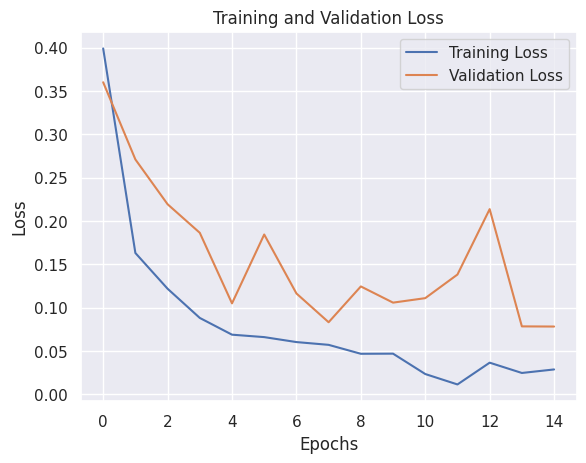

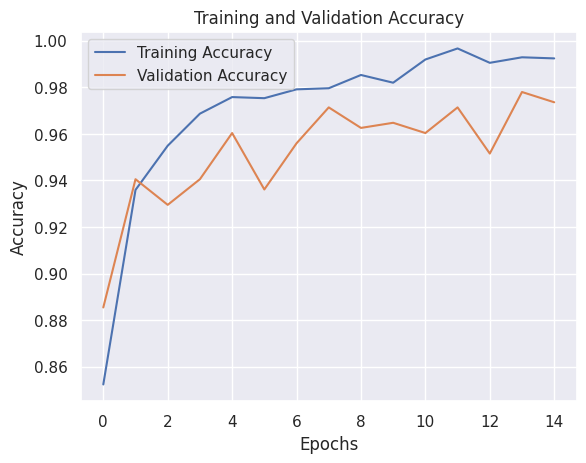

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

##Visualizing Feature Maps

1/1 [==============================] - 0s 415ms/step


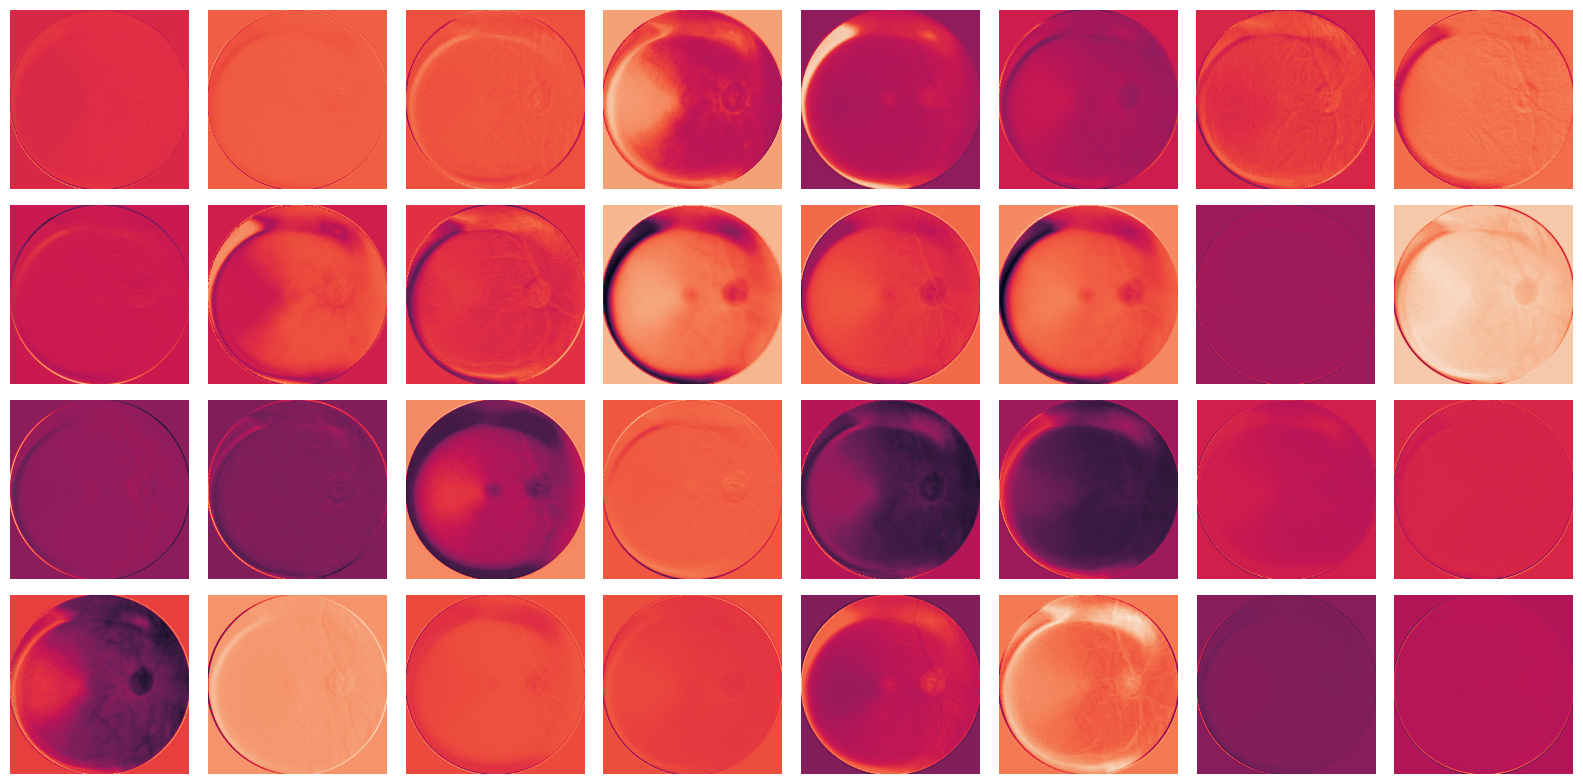

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_96'
img_path = '/content/split_data/valid/cataract/1415_right.jpg'

visualize_activation_maps(model, img_path, layer_name)

##Model Save

In [ ]:
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Cataract/cataract_tl.h5')
model2 = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/Cataract/cataract_tl.h5')

##Model Evaluation

In [ ]:
train = model.evaluate(training_set)
valid = model.evaluate(testing_set)
test = model.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])
print(' ' * 40)
print(' ' * 40)
print("Test Loss: ", test[0])
print("Test Accuracy: ", test[1])

15/15 [==============================] - 20s 1s/step - loss: 0.0783 - accuracy: 0.9736
                                        
                                        
Train Loss:  0.010649727657437325
Train Accuracy:  0.9966777563095093
                                        
                                        
Validation Loss:  0.1725781410932541
Validation Accuracy:  0.9578713774681091
                                        
                                        
Test Loss:  0.07825291901826859
Test Accuracy:  0.9735682606697083


##Error Analysis

In [ ]:
data_dir = '/content/split_data/valid'
class_labels = os.listdir(data_dir)

misclassified_samples = []
for class_label in class_labels:
    class_dir = os.path.join(data_dir, class_label)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = load_img(image_path, target_size=(512, 512))
        input_arr = img_to_array(image)
        input_arr = np.array([input_arr]) / 255.0
        prediction = model.predict(input_arr)
        predicted_class = np.argmax(prediction)
        if predicted_class != class_labels.index(class_label):
            misclassified_samples.append((image_path, class_label, class_labels[predicted_class]))

num_misclassified = 0
for sample in misclassified_samples:
    image_path, true_label, predicted_label = sample
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

    if true_label == predicted_label:
        error_type = 'False Positive'
    else:
        error_type = 'False Negative'

    print(f"Error Type: {error_type}")
    print(f"Image Path: {image_path}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("--------------------------------------")

    num_misclassified += 1
    if num_misclassified >= 100:
        break

Output hidden; open in https://colab.research.google.com to view.

##Predicting an Image Using the Model

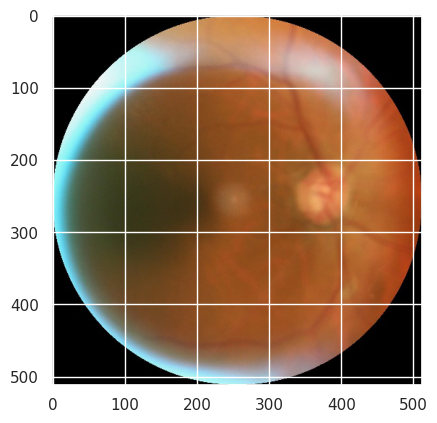

1/1 [==============================] - 0s 29ms/step
Cataract


In [ ]:
image = load_img('/content/split_data/valid/cataract/1415_right.jpg',target_size=(512,512))
plt.imshow(image, cmap='gray')
plt.show()
input_arr = img_to_array(image)
input_arr = np.array([input_arr])
preds = model.predict(input_arr)
y_pred = np.argmax(preds, axis=1)
if y_pred == 1:
    print ("Normal")
else:
    print ("Cataract")

##Visualizing Attension Map

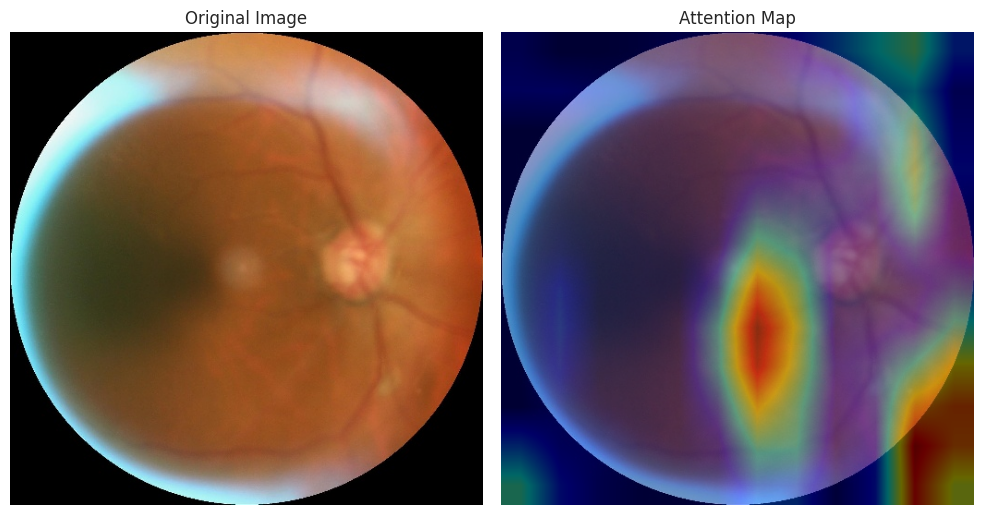

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/split_data/valid/cataract/1415_right.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(512, 512))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_189'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

# Convolutional Neural Network (CNN)

##Creating CNN Model

In [17]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(512, 512, 3)))

model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(512, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 62, 62, 64)       

##Model Training

In [18]:
history = model_cnn.fit(training_set, epochs=15, validation_data=validation_set)

Epoch 1/15
66/66 [==============================] - 219s 3s/step - loss: 0.6753 - accuracy: 0.5918 - val_loss: 0.6187 - val_accuracy: 0.6982
Epoch 2/15
66/66 [==============================] - 203s 3s/step - loss: 0.5533 - accuracy: 0.7290 - val_loss: 0.4637 - val_accuracy: 0.8084
Epoch 3/15
66/66 [==============================] - 202s 3s/step - loss: 0.4804 - accuracy: 0.7969 - val_loss: 0.4009 - val_accuracy: 0.7907
Epoch 4/15
66/66 [==============================] - 200s 3s/step - loss: 0.3671 - accuracy: 0.8443 - val_loss: 0.3706 - val_accuracy: 0.8436
Epoch 5/15
66/66 [==============================] - 205s 3s/step - loss: 0.3411 - accuracy: 0.8529 - val_loss: 0.3491 - val_accuracy: 0.8546
Epoch 6/15
66/66 [==============================] - 205s 3s/step - loss: 0.3155 - accuracy: 0.8576 - val_loss: 0.2951 - val_accuracy: 0.8789
Epoch 7/15
66/66 [==============================] - 204s 3s/step - loss: 0.2728 - accuracy: 0.8799 - val_loss: 0.3090 - val_accuracy: 0.8546
Epoch 8/15
66

##Plotting Training vs Validation Accuracy and Loss

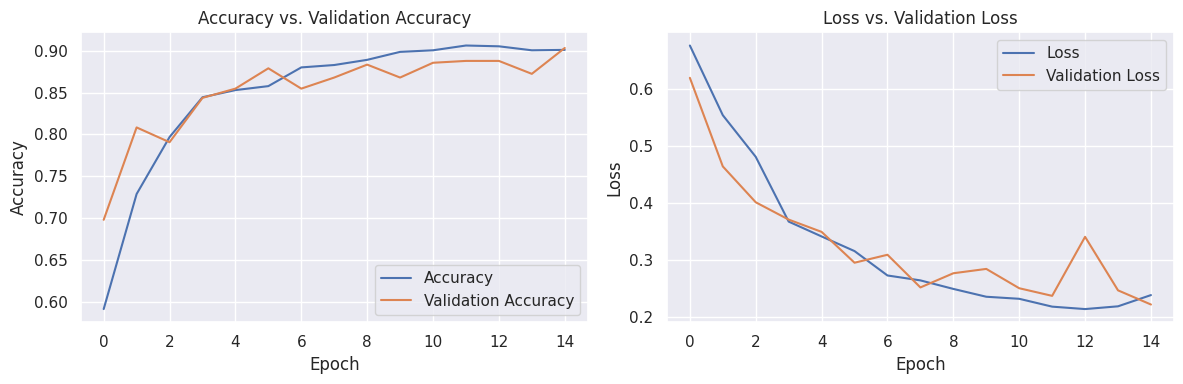

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

##Visualizing Feature Maps

1/1 [==============================] - 0s 99ms/step


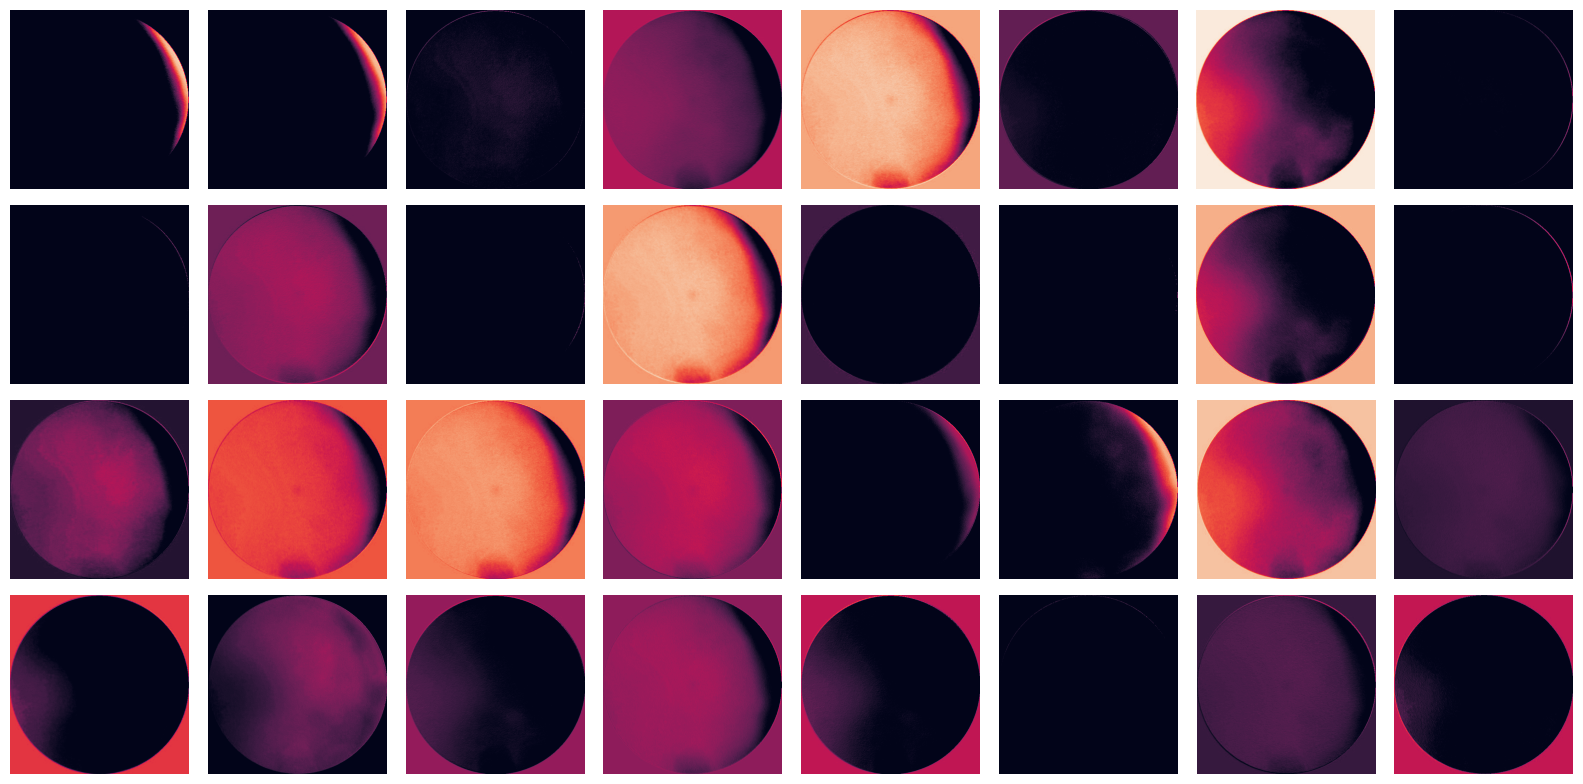

In [26]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_30'
img_path = '/content/split_data/valid/cataract/1285_left.jpg'

visualize_activation_maps(model_cnn, img_path, layer_name)

##Model Evaluation

In [28]:
train = model_cnn.evaluate(training_set)
valid = model_cnn.evaluate(testing_set)
test = model_cnn.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])
print(' ' * 40)
print(' ' * 40)
print("Test Loss: ", test[0])
print("Test Accuracy: ", test[1])

15/15 [==============================] - 16s 1s/step - loss: 0.2220 - accuracy: 0.9031
                                        
                                        
Train Loss:  0.192007377743721
Train Accuracy:  0.9140958786010742
                                        
                                        
Validation Loss:  0.2182665467262268
Validation Accuracy:  0.8913525342941284
                                        
                                        
Test Loss:  0.22197425365447998
Test Accuracy:  0.9030836820602417


##Predicting Image Using the Model

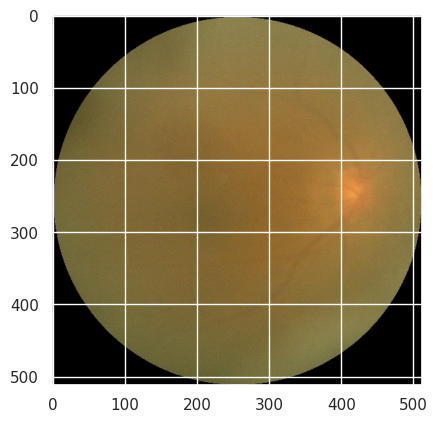

1/1 [==============================] - 0s 67ms/step
Cataract


In [33]:
image = load_img('/content/split_data/test/cataract/1460_right.jpg',target_size=(512,512))
plt.imshow(image, cmap='gray')
plt.show()
input_arr = img_to_array(image)
input_arr = np.array([input_arr])
preds = model_cnn.predict(input_arr)
y_pred = np.argmax(preds, axis=1)
if y_pred == 1:
    print ("Normal")
else:
    print ("Cataract")

##Visualizing Attension Map

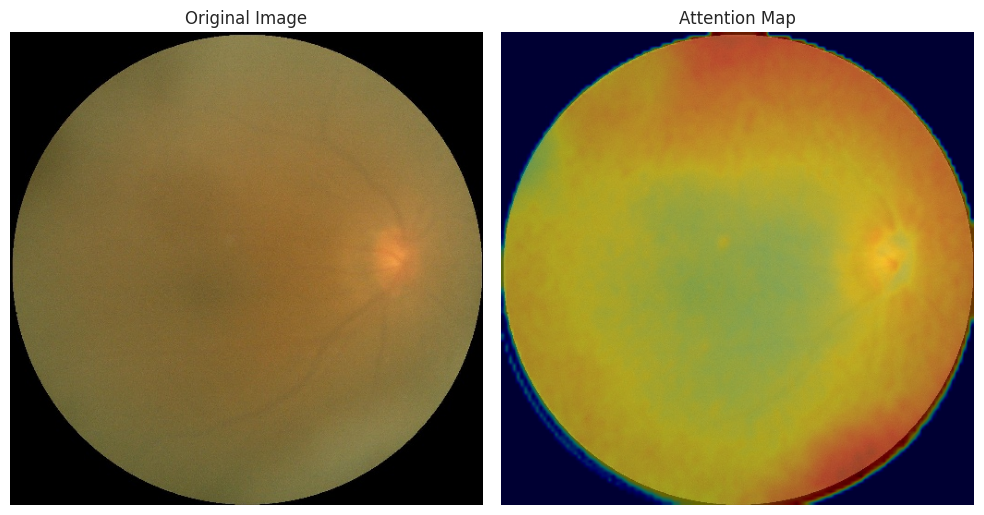

In [35]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/split_data/test/cataract/1460_right.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(512, 512))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_32'
heatmap = get_gradcam(model_cnn, img_array, layer_name)

visualize_attention(image_path, heatmap)